In [2]:
! pip install np_utils

     ---------------------------------------- 62.0/62.0 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56454 sha256=51d93e469d04d9debecac0a506b5b502761ae04798e32f87a79f2b888e44b9d3
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\c9\5e\52\216e2fa9b02d46b865d8160e7fe29dcf98f89a2fb7be254877
Successfully built np_utils


In [5]:
import os

import wave
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from IPython.display import Audio

import librosa
import librosa.display

import np_utils
from keras.layers import concatenate
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv1D, Conv2D, SeparableConv1D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.layers import Input, add, Flatten, Dense, BatchNormalization, Dropout, LSTM, GRU
from tensorflow.keras.layers import GlobalMaxPooling1D, GlobalMaxPooling2D, Activation, LeakyReLU, ReLU
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef
from sklearn.metrics import cohen_kappa_score,roc_auc_score,confusion_matrix,classification_report

In [6]:
audio_data = 'C:/Users/Admin/Documents/respiratory/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'

In [7]:
patient_data=pd.read_csv('C:/Users/Admin/Documents/respiratory/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv',names=['pid','disease'])

In [8]:
diagnosis_df = pd.read_csv('C:/Users/Admin/Documents/respiratory/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv', names=['patient_id', 'disease'])
diagnosis_df.head(4)


,patient_id,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD


In [9]:
print (diagnosis_df.disease.value_counts())
print ('')
print (diagnosis_df.disease.value_counts(normalize=True) *100)


COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: disease, dtype: int64

COPD              50.793651
Healthy           20.634921
URTI              11.111111
Bronchiectasis     5.555556
Pneumonia          4.761905
Bronchiolitis      4.761905
LRTI               1.587302
Asthma             0.793651
Name: disease, dtype: float64


<Axes: xlabel='disease', ylabel='count'>

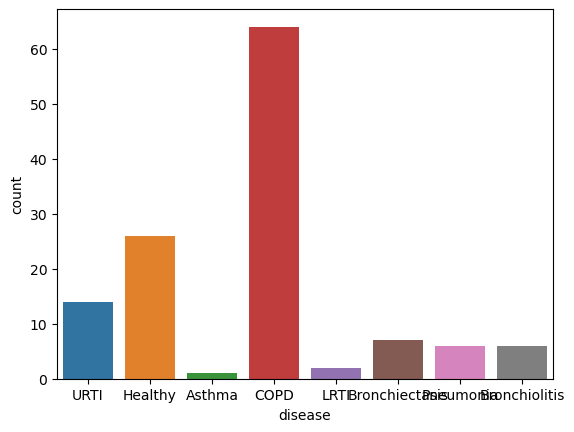

In [10]:
sns.countplot(x='disease', data=diagnosis_df)


In [11]:
path='C:/Users/Admin/Documents/respiratory/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
files=[s.split('.')[0] for s in os.listdir(path) if '.txt' in s]


In [39]:
def add_noise(data,x):
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise

def shift(data,x):
    return np.roll(data, x)

def stretch(data, rate):
    data = librosa.effects.time_stretch(data, rate=rate)
    return data

def pitch_shift (data , rate):
    data = librosa.effects.pitch_shift(data, sr=220250, n_steps=rate)
    return data


In [13]:
def show_audio(audio_path):
    y, sr = librosa.load(audio_path)
    y_noise = add_noise(y, 0.0008)
    y_shift = shift(y, 3200)
    y_stretch_1 = stretch(y, 1.2)
    y_stretch_2 = stretch(y, 0.8)
    y_pitch_shift = pitch_shift(y, 3)

    plt.figure(figsize=(20, 8))

    plt.subplot(3, 2, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title('orginal')

    plt.subplot(3, 2, 2)
    librosa.display.waveshow(y_noise, sr=sr)
    plt.title('noise')

    plt.subplot(3, 2, 3)
    librosa.display.waveshow(y_shift, sr=sr)
    plt.title('shift')

    plt.subplot(3, 2, 4)
    librosa.display.waveshow(y_stretch_1, sr=sr)
    plt.title('stretch 1')

    plt.subplot(3, 2, 5)
    librosa.display.waveshow(y_stretch_2, sr=sr)
    plt.title('stretch 2')

    plt.subplot(3, 2, 6)
    librosa.display.waveshow(y_pitch_shift, sr=sr)
    plt.title('pitch shift')

    plt.tight_layout()




In [14]:
def show_audio_features(audio_path):
    y, sr = librosa.load(audio_path)
    y_noise = add_noise(y , 0.0008)
    y_shift = shift(y,3200)
    y_stretch_1 = stretch(y, 1.2)
    y_stretch_2 = stretch(y, 0.8)
    y_pitch_shift = pitch_shift(y, 3)

    y = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=50)
    y_noise = librosa.feature.mfcc(y=y_noise, sr=sr, n_mfcc=50)
    y_shift = librosa.feature.mfcc(y=y_shift, sr=sr, n_mfcc=50)
    y_stretch_1 = librosa.feature.mfcc(y=y_stretch_1, sr=sr, n_mfcc=50)
    y_stretch_2 = librosa.feature.mfcc(y=y_stretch_2, sr=sr, n_mfcc=50)
    y_pitch_shift = librosa.feature.mfcc(y=y_pitch_shift, sr=sr, n_mfcc=50)

    plt.figure(figsize=(20, 8))
    plt.subplot(3,2,1)
    librosa.display.specshow(librosa.power_to_db(y,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('orginal')

    plt.subplot(3,2,2)
    librosa.display.specshow(librosa.power_to_db(y_noise,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('noise')

    plt.subplot(3,2,3)
    librosa.display.specshow(librosa.power_to_db(y_shift,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('shift')

    plt.subplot(3,2,4)
    librosa.display.specshow(librosa.power_to_db(y_stretch_1,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('stretch 1')

    plt.subplot(3,2,5)
    librosa.display.specshow(librosa.power_to_db(y_stretch_2,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('stretch 2')

    plt.subplot(3,2,6)
    librosa.display.specshow(librosa.power_to_db(y_pitch_shift,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('pitch shift')



    plt.tight_layout()


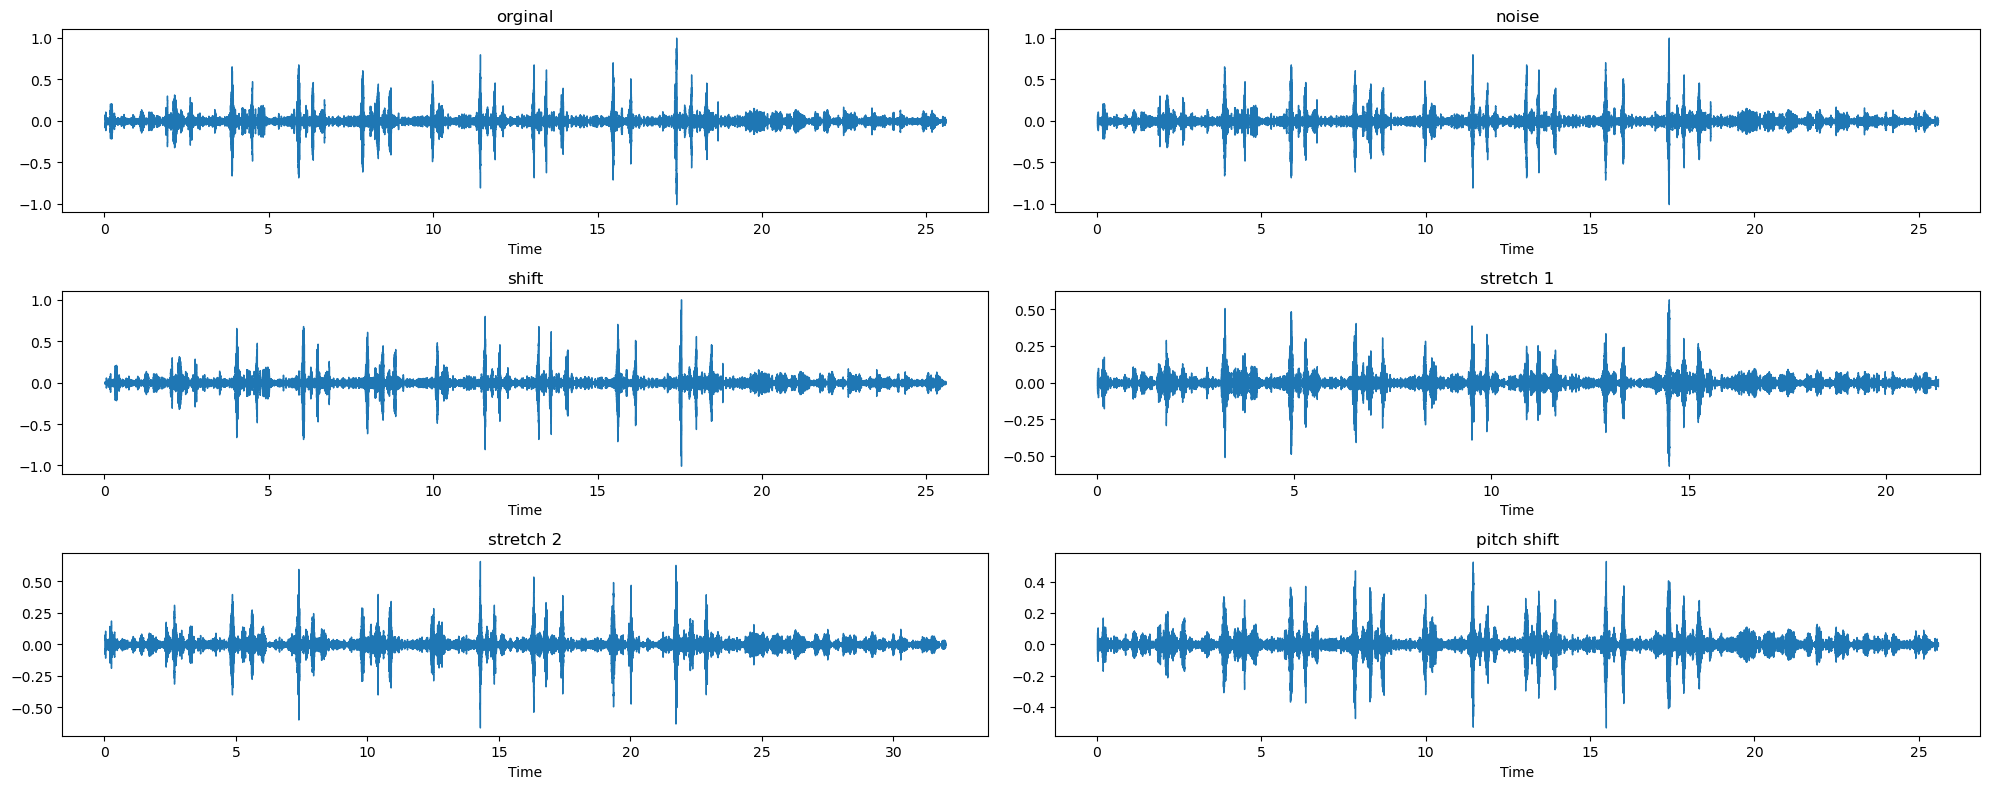

In [15]:
show_audio('C:/Users/Admin/Documents/respiratory/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/104_1b1_Ar_sc_Litt3200.wav')

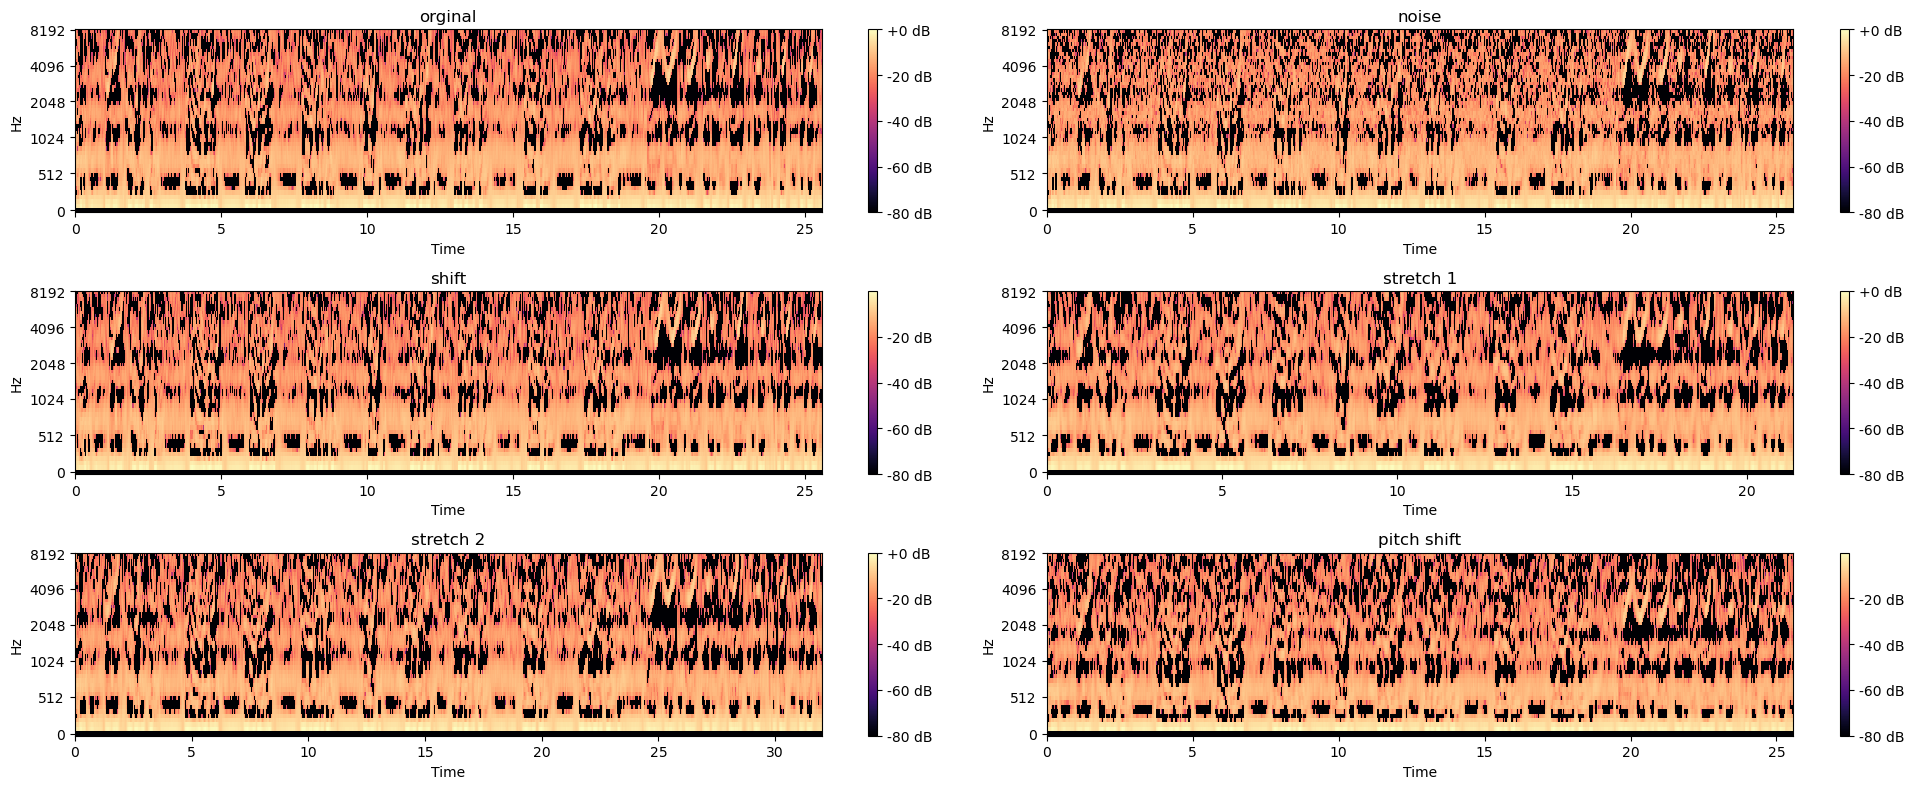

In [16]:
show_audio_features('C:/Users/Admin/Documents/respiratory/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/104_1b1_Ar_sc_Litt3200.wav')

In [17]:
import soundfile as sf

In [18]:
def mfccs_feature_exteraction(dir_):
  X_=[]
  y_=[]
  COPD=[]
  copd_count=0
  data = diagnosis_df
  features = 52
  for soundDir in (os.listdir(dir_)):
    if soundDir[-3:]=='wav'and soundDir[:3]!='103'and soundDir[:3]!='108'and soundDir[:3]!='115':
      p = list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0]
      if (p=='COPD'):
        if (soundDir[:6] in COPD) and copd_count<2:
          data_x, sampling_rate = sf.read(dir_ + soundDir)
          mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
          COPD.append(soundDir[:6])
          copd_count+=1
          X_.append(mfccs)
          y_.append(list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0])
        if (soundDir[:6] not in COPD):
          data_x, sampling_rate = sf.read(dir_ + soundDir)
          mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
          COPD.append(soundDir[:6])
          copd_count=0
          X_.append(mfccs)
          y_.append(list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0])
      if (p!='COPD'):
        if ((p == 'Bronchiectasis') or (p == 'Bronchiolitis')):
          data_x, sampling_rate = sf.read(dir_ + soundDir)
          mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
          X_.append(mfccs)
          y_.append('Bronchiolitis')
          data_noise = add_noise(data_x,0.001)
          mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis=0)
          X_.append(mfccs_noise)
          y_.append('Bronchiolitis')
          data_shift = shift(data_x,1600)
          mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis=0)
          X_.append(mfccs_shift)
          y_.append('Bronchiolitis')
          data_stretch = stretch(data_x,rate=1.2)
          mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis=0)
          X_.append(mfccs_stretch)
          y_.append('Bronchiolitis')
          data_stretch_2 = stretch(data_x,rate=0.8)
          mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=data_stretch_2, sr=sampling_rate, n_mfcc=features).T,axis=0)
          X_.append(mfccs_stretch_2)
          y_.append('Bronchiolitis')
          data_pitch_shift = pitch_shift(data_x,3)
          mfccs_stretch = np.mean(librosa.feature.melspectrogram(y=data_pitch_shift, sr=sampling_rate, n_mels=features).T,axis=0)
          X_.append(mfccs_stretch)
          y_.append('Bronchiolitis')
        else:
          data_x, sampling_rate = sf.read(dir_ + soundDir)
          mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
          X_.append(mfccs)
          y_.append(list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0])
          data_noise = add_noise(data_x,0.001)
          mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis=0)
          X_.append(mfccs_noise)
          y_.append(p)
          data_shift = shift(data_x,1600)
          mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis=0)
          X_.append(mfccs_shift)
          y_.append(p)
          data_stretch = stretch(data_x,rate=1.2)
          mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis=0)
          X_.append(mfccs_stretch)
          y_.append(p)
          data_stretch_2 = stretch(data_x,rate=0.8)
          mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=data_stretch_2, sr=sampling_rate, n_mfcc=features).T,axis=0)
          X_.append(mfccs_stretch_2)
          y_.append(p)
          data_pitch_shift = pitch_shift(data_x,3)
          mfccs_stretch = np.mean(librosa.feature.melspectrogram(y=data_pitch_shift, sr=sampling_rate, n_mels=features).T,axis=0)
          X_.append(mfccs_stretch)
          y_.append(p)
  X_data = np.array(X_)
  y_data = np.array(y_)
  return X_data, y_data


In [19]:
x_mfccs,y = mfccs_feature_exteraction(audio_data)

In [20]:
def augmented_lables_count(lables):
    unique, counts = np.unique(lables, return_counts=True)
    data_count = dict(zip(unique, counts))

    data = data_count

    courses = list(data.keys())
    values = list(data.values())

    fig = plt.figure(figsize = (10, 5))

    # creating the bar plot
    plt.bar(courses, values, color =['orange','green','blue','red','yellow','black'],
            width = 0.4)

    plt.xlabel("Diseases")
    plt.ylabel("Count")
    plt.title("Count of each disease")
    plt.show()
    print (data_count)


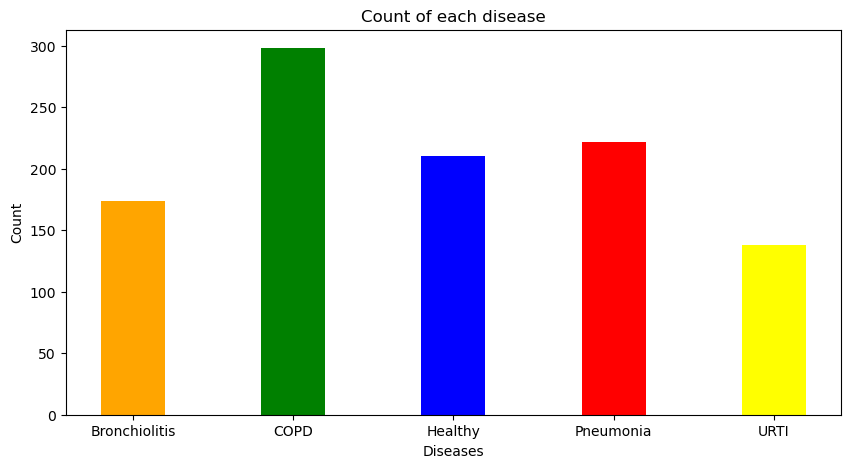

{'Bronchiolitis': 174, 'COPD': 298, 'Healthy': 210, 'Pneumonia': 222, 'URTI': 138}


In [21]:
augmented_lables_count(y)

In [22]:
y_data_encode = y.reshape(y.shape[0],1)
y_data_encode = np.where(y_data_encode == 'COPD',np.array([1,0,0,0,0]).reshape(1,5) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'Bronchiolitis',np.array([0,1,0,0,0]).reshape(1,5) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'Pneumonia',np.array([0,0,1,0,0]).reshape(1,5) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'URTI',np.array([0,0,0,1,0]).reshape(1,5) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'Healthy',np.array([0,0,0,0,1]).reshape(1,5) , y_data_encode)

Y_data = y_data_encode.astype('float64')

In [23]:
mfccs_features = np.array(x_mfccs)
lables = np.array(Y_data)

mfccs_features.shape , lables.shape

((1042, 52), (1042, 5))

In [24]:
mfcc_train, mfcc_val, lables_train, lables_val  = train_test_split(mfccs_features, lables, test_size=0.175, random_state=10)
mfcc_train, mfcc_test, lables_train, lables_test = train_test_split(mfcc_train, lables_train, test_size=0.075, random_state=10)

print (mfcc_train.shape, mfcc_val.shape, mfcc_test.shape)
print (lables_train.shape, lables_val.shape, lables_test.shape)

(794, 52) (183, 52) (65, 52)
(794, 5) (183, 5) (65, 5)


In [25]:
x_train_lstm = np.expand_dims(mfcc_train,axis=2)
x_val_lstm = np.expand_dims(mfcc_val,axis=2)
x_test_lstm = np.expand_dims(mfcc_test,axis=2)

In [26]:
lstm_model = Sequential()

lstm_model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(52, 1)))
lstm_model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
lstm_model.add(BatchNormalization())

lstm_model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(52, 1)))
lstm_model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
lstm_model.add(BatchNormalization())

lstm_model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
lstm_model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
lstm_model.add(BatchNormalization())

lstm_model.add(LSTM(256, return_sequences=True))
lstm_model.add(LSTM(128))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dropout(0.5))

lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dropout(0.5))

lstm_model.add(Dense(5, activation='softmax'))

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 52, 2048)          12288     
                                                                 
 max_pooling1d (MaxPooling1  (None, 26, 2048)          0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 26, 2048)          8192      
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 26, 1024)          10486784  
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 13, 1024)          0         
 g1D)                                                            
                                                        

In [28]:
! pip install pydot

In [29]:
! pip install pydotplus

     -------------------------------------- 278.7/278.7 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24578 sha256=f01b4fd89bf31902df91770a3f269888f100a79d19267dba313321c910c5cd4f
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\5c\94\1f\953aa60af58ef512e5256e538ff0772c340229e5996ac51fd6
Successfully built pydotplus


In [30]:
! pip install graphviz

In [33]:
optimiser = tf.keras.optimizers.Adam(learning_rate = 0.0001)
lstm_model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cb = [EarlyStopping(patience=20,monitor='val_accuracy',mode='max',restore_best_weights=True),
      ModelCheckpoint("/kaggle/working/diagnosis_LSTM_CNN_1.h5",save_best_only=True)]

In [34]:
history = lstm_model.fit(x_train_lstm, lables_train, batch_size=8, epochs=30, validation_data=(x_val_lstm, lables_val),callbacks = cb )

Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: 1.5752 - accuracy: 0.2657

C:\Users\Admin\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 92s 803ms/step - loss: 1.5752 - accuracy: 0.2657 - val_loss: 1.5404 - val_accuracy: 0.3880
Epoch 2/30
100/100 [==============================] - 80s 800ms/step - loss: 1.4875 - accuracy: 0.3388 - val_loss: 1.4263 - val_accuracy: 0.4098
Epoch 3/30
100/100 [==============================] - 78s 779ms/step - loss: 1.4364 - accuracy: 0.3967 - val_loss: 1.3704 - val_accuracy: 0.5082
Epoch 4/30
100/100 [==============================] - 80s 801ms/step - loss: 1.3495 - accuracy: 0.4181 - val_loss: 1.4598 - val_accuracy: 0.3825
Epoch 5/30
100/100 [==============================] - 76s 765ms/step - loss: 1.3020 - accuracy: 0.4131 - val_loss: 1.2048 - val_accuracy: 0.4098
Epoch 6/30
100/100 [==============================] - 76s 758ms/step - loss: 1.2724 - accuracy: 0.4572 - val_loss: 1.2982 - val_accuracy: 0.5246
Epoch 7/30
100/100 [==============================] - 80s 796ms/step - loss: 1.2820 - accuracy: 0.4710 - val_loss: 1.1139 - val_accuracy: 0.5

In [35]:
lstm_model.evaluate(x_val_lstm, lables_val)

6/6 [==============================] - 2s 252ms/step - loss: 0.5619 - accuracy: 0.7814


[0.5618987083435059, 0.7814207673072815]

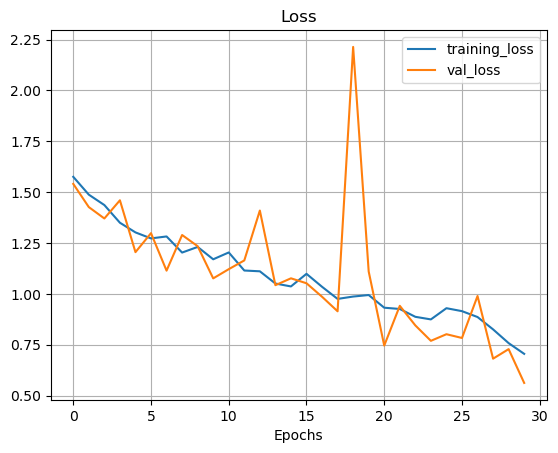

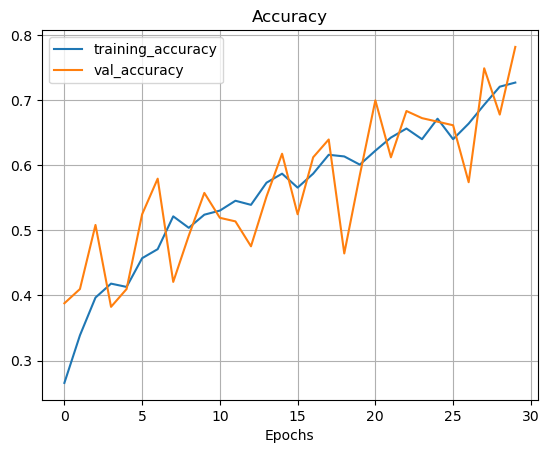

In [37]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(history.history['loss']))
    #Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid()
    plt.figure()
    plt.grid()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();
plot_loss_curves(history)
    

3/3 [==============================] - 3s 189ms/step


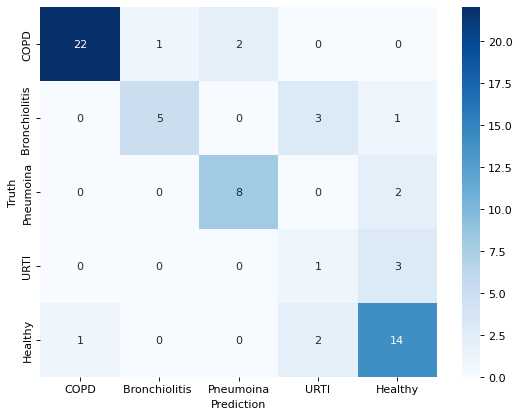

In [38]:
classes = ["COPD" ,"Bronchiolitis ", "Pneumoina", "URTI", "Healthy"]

preds = lstm_model.predict(x_test_lstm)
classpreds = [ np.argmax(t) for t in preds ]
y_testclass = [np.argmax(t) for t in lables_test]
cm = confusion_matrix(y_testclass, classpreds)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

plt.title('')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [40]:
print(classification_report(y_testclass, classpreds, target_names=classes))

                precision    recall  f1-score   support

          COPD       0.96      0.88      0.92        25
Bronchiolitis        0.83      0.56      0.67         9
     Pneumoina       0.80      0.80      0.80        10
          URTI       0.17      0.25      0.20         4
       Healthy       0.70      0.82      0.76        17

      accuracy                           0.77        65
     macro avg       0.69      0.66      0.67        65
  weighted avg       0.80      0.77      0.78        65

